# Install Necessary Pacakges

In [4]:
! pip install iterative-stratification

# Unzip and Create Data File

In [2]:
# alternative, use google colab and google drive
# from google.colab import drive
# drive.mount('/content/drive')

!mkdir moa_data
%cd moa_data
!unzip /content/lish-moa.zip
%cd /content/

mkdir: cannot create directory ‘moa_data’: File exists
/content/moa_data
Archive:  /content/lish-moa.zip
  inflating: sample_submission.csv   
  inflating: test_features.csv       
  inflating: train_drug.csv          
  inflating: train_features.csv      
  inflating: train_targets_nonscored.csv  
  inflating: train_targets_scored.csv  
/content


# Import Necessary Packages

In [5]:
import datetime
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from IPython.display import SVG
import keras
from keras import layers
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from time import time
import warnings
plt.style.use('seaborn-poster')
warnings.filterwarnings("ignore")

# Custom Function Define

In [6]:
def df_pre_processing(raw_df, type='training', verbose=True):
    # expand features 2 non-numerical features 'cp_type', 'cp_dose' to 4 dummy 
    # features based on categorical values 
    processed_df = pd.concat([raw_df, pd.get_dummies(raw_df['cp_dose'], prefix='cp_dose')], axis=1)
    processed_df = pd.concat([processed_df, pd.get_dummies(raw_df['cp_type'], \
                                                                           prefix='cp_type')], axis=1)

    # drop the three original features
    processed_df = processed_df.drop(['cp_type', 'cp_dose'], axis=1)

    # removed the samples with wrong cp_type -- removed 1866 samples
    processed_df = processed_df.loc[processed_df['cp_type_trt_cp']==1].reset_index(drop=True)

    # drop the original sig_id column
    processed_df = processed_df.drop(columns='sig_id')

    # show shape of processed df
    if verbose:
        print(f"Processed {type} dataset shape = {processed_df.shape}.")
        
    return processed_df

# -----------------------------------------------------------------------------#

def create_DNN_base_line_model(input_dim = 877,
                               first_layer_dim = 300,
                               second_layer_dim = 300,
                               third_layer_dim = 300,
                               first_kernel_layer_dim = 300, 
                               second_kernel_layer_dim = 206, 
                               output_layer_dim = 206, 
                               first_dropout_rate = 0.6,
                               second_dropout_rate = 0.6,
                               third_dropout_rate = 0.6,
                               first_layer_activation_func = 'relu', 
                               second_layer_activation_func = 'relu', 
                               third_layer_activation_func = 'relu',
                               fourth_layer_activation_func = 'relu', 
                               first_kernel_initializer ='lecun_normal',
                               second_kernel_initializer ='lecun_normal',
                               first_kernel_layer_activation_func = 'selu',
                               second_kernel_layer_activation_func = 'selu', 
                               output_activation_func = 'sigmoid'):

    # Create DNN base line model using keras
    # sequential style and active drop out layers
    # write it as function for potential opportunities
    # to optimize the model
    input_layer = keras.Input(shape=(input_dim,))
    first_layer = layers.Dense(first_layer_dim, activation=first_layer_activation_func)(input_layer)
    first_dropout_layer = layers.Dropout(first_dropout_rate)(first_layer )
    second_layer = layers.Dense(second_layer_dim, activation=second_layer_activation_func)(first_dropout_layer)
    second_dropout_layer = layers.Dropout(second_dropout_rate)( second_layer )
    third_layer = layers.Dense(second_layer_dim, activation=second_layer_activation_func)(second_dropout_layer)
    third_dropout_layer = layers.Dropout(third_dropout_rate)( third_layer )
    first_kernel_layer = layers.Dense(first_kernel_layer_dim, kernel_initializer = first_kernel_initializer, activation = first_kernel_layer_activation_func, name = 'last_frozen' )(third_dropout_layer)
    second_kernel_layer = layers.Dense(second_kernel_layer_dim, kernel_initializer = second_kernel_initializer, activation = first_kernel_layer_activation_func)(first_kernel_layer)
    output_layer = layers.Dense(output_layer_dim, activation=output_activation_func)(second_kernel_layer)
    DNN_model =  keras.Model(input_layer, output_layer)
    return DNN_model

# -----------------------------------------------------------------------------#

def get_average_metrics_out_of_cv_folds(history_list):
    # Derive total number of folds and 
    # total number epochs
    total_n_folds = len(history_list)
    total_epochs = len(hist_total_list[0].history['loss'])
    mean_loss = np.zeros([total_n_folds,total_epochs])
    mean_val_loss = np.zeros([total_n_folds,total_epochs])
    
    # Put loss and validation loss in each fold
    for i in range(total_n_folds):
        mean_loss[i,:] = history_list[i].history['loss']
        mean_val_loss[i,:] = history_list[i].history['val_loss']

    # Get average loss and validation loss
    mean_loss = np.mean(mean_loss,axis=0)
    mean_val_loss  = np.mean(mean_val_loss ,axis=0)
    return mean_loss, mean_val_loss

# Partition and Preprocess Training-Testing Data

In [7]:
data_path = "moa_data/"
# data_path = "/content/drive/MyDrive/Colab Notebooks/MoA/lish-moa/"

# Load in data set
train_features_y1 = pd.read_csv(data_path + "train_targets_scored.csv")
train_features1 = pd.read_csv(data_path + "train_features.csv")


# Preprocess training feature 
train_features1_processed = df_pre_processing(train_features1, type='training', verbose=True)

# Preprocess training labels
train_features_y1_processed  = train_features_y1.loc[train_features1['cp_type']=='trt_cp'].reset_index(drop=True)
train_features_y1_processed = train_features_y1_processed.drop("sig_id", axis= 1)

Processed training dataset shape = (21948, 877).


# Apply CV Scheme Into Training the Baseline DNN

In [8]:
# Total number of fitting = N_STARTS x N_SPLITS
N_STARTS = 3
N_SPLITS = 3
res = train_features1_processed.copy()
res.loc[:, train_features_y1_processed.columns] = 0
hist_total_list = []

for seed in range(N_STARTS):
    start_time_seed = time()
    K.clear_session()
    tf.random.set_seed(seed)
    mean_score = 0
    # Splitting scheme: StratifiedKFold
    skf = MultilabelStratifiedKFold(n_splits = N_SPLITS, random_state = 42, shuffle = True)
    for n, (tr, te) in enumerate(skf.split(train_features_y1_processed, train_features_y1_processed)):
        
        start_time_fold = time()
        x_tr, x_val = train_features1_processed, train_features1_processed
        y_tr, y_val = train_features_y1_processed, train_features_y1_processed

        # Generate and compile new models    
        model = create_DNN_base_line_model()
        model.compile(optimizer="Nadam", loss = "BinaryCrossentropy") 
        
        # Set up early stopper and adaptative learning rate
        rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 3, 
                                verbose = 0, min_delta = 1e-4, mode = 'min')
        es = EarlyStopping(monitor = 'val_loss', min_delta = 1e-4, patience = 10, mode = 'min', 
                           baseline = None, restore_best_weights = True, verbose = 0)
        history = model.fit(x_tr, y_tr, validation_data = (x_val, y_val), epochs = 10, 
                            batch_size = 32, callbacks = [rlr, es], verbose = 0)
        
        hist_total_list.append(history)
        hist = pd.DataFrame(history.history)
        fold_score = hist['val_loss'].min()
        mean_score += fold_score / N_SPLITS
        val_predict = model.predict(train_features1_processed.values[te])
        res.loc[te, train_features_y1_processed.columns] += val_predict / N_STARTS
        print(f'[{str(datetime.timedelta(seconds = time() - start_time_fold))[2:7]}] Seed {seed}, Fold {n}:', fold_score)
    print(f'[{str(datetime.timedelta(seconds = time() - start_time_seed))[2:7]}] Seed {seed} Mean Score:', mean_score)

[00:52] Seed 0, Fold 0: 0.017173973843455315
[00:44] Seed 0, Fold 1: 0.01709113083779812
[00:43] Seed 0, Fold 2: 0.017116349190473557
[02:22] Seed 0 Mean Score: 0.017127151290575664
[00:44] Seed 1, Fold 0: 0.01725771278142929
[00:45] Seed 1, Fold 1: 0.017148735001683235
[00:44] Seed 1, Fold 2: 0.0172832440584898
[02:16] Seed 1 Mean Score: 0.017229897280534107
[00:44] Seed 2, Fold 0: 0.017247596755623817
[00:44] Seed 2, Fold 1: 0.017177265137434006
[00:44] Seed 2, Fold 2: 0.01723196543753147
[02:15] Seed 2 Mean Score: 0.017218942443529766


# Plot Loss and Accuracy vs. Epochs

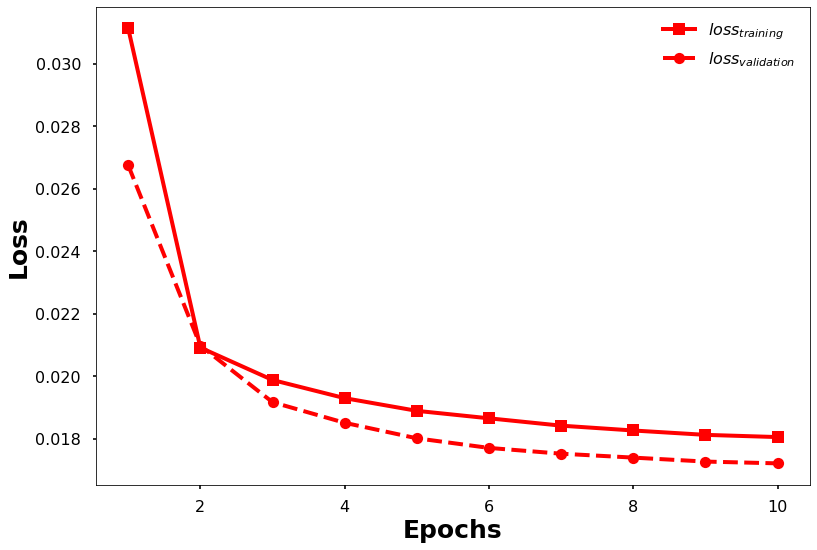

In [9]:
# Get average loss and validation loss out of all folds
mean_loss,mean_val_loss = get_average_metrics_out_of_cv_folds(hist_total_list)

# Plot Loss and Accuracy vs. Epochs
plt.figure()
plt.plot(np.arange(1,len(mean_loss)+1,1),np.array(mean_loss),'-s',lw=4,label=r'$loss_{training}$',c='r')
plt.plot(np.arange(1,len(mean_val_loss )+1,1),np.array(mean_val_loss ),'--o',lw=4,label=r'$loss_{validation}$',c='r')
plt.ylabel('Loss',fontsize = 25,fontweight='bold')
plt.xlabel("Epochs",fontsize = 25,fontweight='bold')
plt.legend(loc=1,frameon=False)
plt.show()

# Show Model Architecture

In [10]:
print('Model Summary for DNN Baseline Model: ')
SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
                 rankdir='TB', dpi=60).create(prog='dot', format='svg'))

print('\n')
print(model.summary())

Model Summary for DNN Baseline Model: 


Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 877)]             0         
_________________________________________________________________
dense_10 (Dense)             (None, 300)               263400    
_________________________________________________________________
dropout_6 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 300)               90300     
_________________________________________________________________
dropout_7 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 300)               90300     
_________________________________________________________________
dropout_8 (Dr